# Enhanced Collaborative Beer Recommender with Content Features

This notebook extends our baseline collaborative filtering model by incorporating beer-specific content features to build a **hybrid recommender system**. The goal is to improve prediction accuracy by enriching user-beer interactions with additional item metadata such as **ABV (Alcohol by Volume)** and **style**.

## Objective
To enhance the capability of the collaborative model to generalize for:
- **Sparse users** (users with few reviews)
- **Cold-start beers** (beers with limited review history)
- **Contextual personalization** using beer content attributes

## Key Enhancements
- Encoding and normalizing beer attributes (e.g., `style_encoded`, `abv_normalized`)
- Integrating beer feature tensors into the model architecture
- Modifying the forward pass to include content-aware representations
- Evaluating performance improvements over the vanilla collaborative model

This hybrid approach aims to deliver more personalized and accurate recommendations by combining **collaborative signals (user-beer interactions)** with **content signals (beer features)**.

The model will later be compared with both the vanilla collaborative and content-only models for a holistic understanding of trade-offs in accuracy and generalization.


---

### Loading and Normalizing Dataset

This section loads the final preprocessed dataset (`final_beers_reviews_breweries.csv`), which contains integrated information about beers, breweries, and user reviews. Each row represents a unique review tied to a beer and its associated brewery metadata.

To ensure consistency in model training, all review-related rating columns (`look`, `smell`, `taste`, `feel`, `overall`, and `score`) are normalized to the range [0, 1] using `MinMaxScaler`. This normalization step is important to avoid bias caused by differences in scale across features.


In [1]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

if device.type == "cuda":
    idx = device.index or 0
    print("GPU name: ", torch.cuda.get_device_name(idx))
elif device.type == "mps":
    print("Running on Apple Silicon GPU via MPS")
else:
    print("Running on CPU")

Using device: cuda
GPU name:  NVIDIA GeForce RTX 3080


In [2]:
# Loading Dataset

import pandas as pd

try:
    df = pd.read_csv('final_beers_reviews_breweries.csv')
    print("\final Data Sample:")
    print(df.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

inal Data Sample:
              name state country                    style availability   abv  \
0  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
1  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
2  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
3  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
4  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   

                                               notes  beer_id     username  \
0  Imperial Stout aged for 12 months in new bourb...    34094        Sazz9   
1  Imperial Stout aged for 12 months in new bourb...    34094  Amguerra305   
2  Imperial Stout aged for 12 months in new bourb...    34094      TheGent   
3  Imperial Stout aged for 12 months in new bourb...    34094         bobv   
4  Imperial Stout aged for 12 months in new bourb...    34094      Tony210   

         date  ...  look  smell

In [3]:
# Normalize rating-related columns to [0, 1] range to ensure consistent scale across features for training

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['look', 'smell', 'taste', 'feel', 'overall', 'score']] = scaler.fit_transform(
    df[[ 'look', 'smell', 'taste', 'feel', 'overall', 'score']]
)


In [4]:
df.describe()

,abv,beer_id,look,smell,taste,feel,overall,score
count,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000
mean,7.582153,13682.230450,0.754612,0.736018,0.755178,0.738499,0.751018,0.748170
std,2.353999,20065.492805,0.142259,0.159482,0.163359,0.155050,0.158492,0.140153
min,2.500000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.600000,689.000000,0.687500,0.625000,0.687500,0.625000,0.687500,0.687500
50%,7.200000,2137.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.770000
75%,9.100000,21300.000000,0.875000,0.875000,0.875000,0.875000,0.875000,0.837500
max,18.000000,148052.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---

### Beer Content Feature Preprocessing

This section prepares the content-based features that describe each beer for use in the hybrid recommendation model.

- We extract the `beer_id`, `abv` (Alcohol by Volume), and `style` from the full dataset.
- Each beer is represented only once by dropping duplicate entries using `drop_duplicates()`.
- The `style` column, a categorical feature, is encoded using `LabelEncoder` to convert textual styles into numerical representations.
- The final beer feature tensor is constructed using PyTorch, combining `abv` and the encoded `style` into a numerical representation.
- A dictionary (`beerFeatureIndexMap`) is created to map each `beer_id` to its corresponding index in the feature tensor. This allows for easy lookup during model training and inference.


In [5]:
######## UPDATED #########
# Preprocess the beer content features

# Preprocess beer content features
beerMeta = df[['beer_id', 'abv', 'style']].drop_duplicates().set_index('beer_id')

# Encode categorical 'style'
from sklearn.preprocessing import LabelEncoder
style_encoder = LabelEncoder()
beerMeta['style_encoded'] = style_encoder.fit_transform(beerMeta['style'])

# Final feature tensor: abv + style_encoded
beerFeatureTensor = torch.tensor(
    beerMeta[['abv', 'style_encoded']].values,
    dtype=torch.float32
)

# Mapping beer_id to feature index
beerFeatureIndexMap = {beer_id: i for i, beer_id in enumerate(beerMeta.index)}

### Mapping Users and Beers to Index Values

In this section, we convert the unique user and beer identifiers into integer indices. This step is essential for embedding lookups in neural network models, which require numerical inputs.

- Unique usernames and beer IDs are extracted and assigned index values using `enumerate()`.
- These mappings (`userIndexDict` and `beerIndexDict`) are then used to add two new columns: `userIndex` and `beerIndex`, which contain the integer indices for each row in the dataset.
- These indexed columns will later be used to look up the corresponding user and beer embeddings in the collaborative model.
- Finally, the dataset is split into an 80% training set and a 20% validation set using `train_test_split()` to evaluate model performance on unseen data.

**Statistics:**
- Number of unique users: **15,894**
- Number of unique beers: **500**
- Training set size: **491,620**
- Validation set size: **122,905**


In [6]:
# Map usernames and beer IDs to integer indices for embedding lookup

from sklearn.model_selection import train_test_split

# Create mapping dictionaries for users and beers
users = df['username'].unique()
userIndexDict = {user: idx for idx, user in enumerate(users)}

beers = df['beer_id'].unique()
beerIndexDict = {beer: idx for idx, beer in enumerate(beers)}

# Map the original columns to new index columns
df['userIndex'] = df['username'].map(userIndexDict)
df['beerIndex'] = df['beer_id'].map(beerIndexDict)

print("Number of unique users:", len(userIndexDict))
print("Number of unique beers:", len(beerIndexDict))

Number of unique users: 15894
Number of unique beers: 500


In [7]:
# Split the data (e.g., 80% training, 20% validation)
trainDf, valDf = train_test_split(df, test_size=0.2, random_state=42)

print("Training set shape:", trainDf.shape)
print("Validation set shape:", valDf.shape)


Training set shape: (491620, 23)
Validation set shape: (122905, 23)


----

### Constructing a PyTorch Dataset for Enhanced Collaborative Model

This section defines a custom PyTorch `Dataset` class to prepare our training and validation data for the enhanced collaborative model. Each sample in the dataset includes:

- `user`: Index of the user (for user embedding)
- `beer`: Index of the beer (for beer embedding)
- `feature_idx`: Index pointing to the beer's content features (e.g., ABV and style)
- `score`: The normalized rating score given by the user

---

#### Key Update from Previous Version:

In the earlier version, the dataset only returned `user`, `beer`, and `score`. The updated version introduces a new key: `feature_idx`.

- `feature_idx` is mapped from the original `beer_id` using `beerFeatureIndexMap`.
- This index is necessary to retrieve the beer content features (`abv` and `style_encoded`) from the preprocessed tensor `beerFeatureTensor`.

This enhancement enables the recommender model to not only learn user and beer interactions but also incorporate **explicit beer content features**, making the system hybrid (collaborative + content-aware).


In [8]:
# Define a PyTorch Dataset class to return user, beer, and score tensors for each sample

import torch
from torch.utils.data import Dataset

class BeerDataset(Dataset):
    def __init__(self, df, featureIndexMap):
        self.user_ids = df['userIndex'].values
        self.beer_ids = df['beerIndex'].values
        self.scores = df['score'].values.astype('float32')
        self.feature_indices = df['beer_id'].map(featureIndexMap).values

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'beer': torch.tensor(self.beer_ids[idx], dtype=torch.long),
            'feature_idx': torch.tensor(self.feature_indices[idx], dtype=torch.long),
            'score': torch.tensor(self.scores[idx], dtype=torch.float)
        }
trainDataset = BeerDataset(trainDf, beerFeatureIndexMap)
valDataset = BeerDataset(valDf, beerFeatureIndexMap)


### Data Loaders for Training and Validation

After defining the custom `BeerDataset`, the training and validation datasets are wrapped using PyTorch’s `DataLoader`:

- `trainLoader`: Loads the training set in batches of 256 with shuffling enabled to improve training generalization.
- `valLoader`: Loads the validation set in batches of 256 without shuffling to preserve order during evaluation.

These loaders enable efficient mini-batch training and evaluation, essential for handling large-scale datasets like ours.


In [9]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)


---

---

### Enhanced Collaborative Models with Beer Content Features

This section introduces three upgraded neural collaborative filtering models that integrate **beer content features** (ABV and style) into their architectures. By doing so, we transition from pure collaborative filtering to a **hybrid recommendation approach**.

> **Objective**:  
We are experimenting with these three hybrid models to **evaluate their performance** and **determine the most effective architecture** for our final beer recommender system. The goal is to identify which model best captures both user-beer interactions and content-based characteristics for more accurate predictions.

---

#### Common Inputs
All three models utilize:
- `userIndex`: User embeddings
- `beerIndex`: Beer embeddings
- `feature_idx`: Index to lookup beer content feature vector
- `beer_features`: A tensor containing the normalized features (ABV and encoded style)

---

#### 1. `MF_Recommender`: Dot Product + Beer Features
- Combines matrix factorization interaction (`user * beer`) with a shallow network for beer content encoding.
- Final score is computed via a linear layer over the concatenation of the interaction and content vector.

**Architecture Summary**:
- Embedding dim: 32  
- Content encoder: 2 → 16 neurons  
- Output: 17 → 1

---

#### 2. `NonLinear_MF_Recommender`: MLP-Based Hybrid Model
- Replaces dot product with a full MLP to learn interactions between concatenated user, beer, and beer features.
- Adds depth to capture nonlinear user-beer relationships.

**Architecture Summary**:
- Embedding dim: 32  
- Content encoder: 2 → 16  
- MLP: [80 → 64 → 1]

---

#### 3. `NeuMF_Recommender`: Neural Matrix Factorization + Content
- Combines **GMF** and **MLP** streams, then fuses them with a beer content encoder.
- Offers flexibility by blending linear and nonlinear pathways with content information.

**Architecture Summary**:
- GMF & MLP Embeddings: 64  
- MLP Layers: [128, 64, 32, 16]  
- Content encoder: 2 → 16  
- Fusion layer input: 64 + 16 + 16 → 96 → 1

---

By comparing training/validation losses and recommendation quality, we aim to **select the most effective model** to deploy in our final system.


In [10]:
###### UPDATED ####### HYBRID with features
import torch.nn as nn

class MF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, num_content_features, embedding_dim=32):
        super(MF_Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        nn.init.normal_(self.user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

        # Beer content feature encoder
        self.beer_content_fc = nn.Sequential(
            nn.Linear(num_content_features, 16),  # e.g., 2 for [abv, style_encoded]
            nn.ReLU()
        )

        # Final prediction layer
        self.output_layer = nn.Linear(1 + 16, 1)
        
    def forward(self, user, beer, feature_idx, beer_features):
        user_emb = self.user_embedding(user)       # (batch, embed_dim)
        beer_emb = self.beer_embedding(beer)       # (batch, embed_dim)
        interaction = (user_emb * beer_emb).sum(dim=1, keepdim=True)  # (batch, 1)

        # Lookup and encode content features
        beer_content = beer_features[feature_idx]  # (batch, num_content_features)
        beer_content_emb = self.beer_content_fc(beer_content)

        # Concatenate interaction + content encoding
        x = torch.cat([interaction, beer_content_emb], dim=1)
        rating = self.output_layer(x).squeeze(1)

        # Add bias
        u_bias = self.user_bias(user).squeeze(1)
        b_bias = self.beer_bias(beer).squeeze(1)
        rating = rating + u_bias + b_bias + self.global_bias

        # Clamp between 0 and 1
        rating = rating.clamp(min=0.0, max=1.0)
        return rating

# Initialize model parameters
userCount = len(userIndexDict)
beerCount = len(beerIndexDict)
num_content_features = beerFeatureTensor.shape[1]  # Automatically get number of beer features

mf_model = MF_Recommender(
    num_users=userCount,
    num_beers=beerCount,
    num_content_features=num_content_features,
    embedding_dim=32
)

mf_model = mf_model.to(device)

for name, param in mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

global_bias () True
user_embedding.weight (15894, 32) True
beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
beer_content_fc.0.weight (16, 2) True
beer_content_fc.0.bias (16,) True
output_layer.weight (1, 17) True
output_layer.bias (1,) True


In [11]:
###### UPDATED ####### HYBRID with features

import torch.nn as nn

class NonLinear_MF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, num_content_features, embedding_dim=32, hidden_dim=64):
        super(NonLinear_MF_Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)

        # Beer content feature encoder
        self.beer_content_fc = nn.Sequential(
            nn.Linear(num_content_features, 16),
            nn.ReLU()
        )

        # Update input size: user + beer + beer_content
        self.fc1 = nn.Linear(2 * embedding_dim + 16, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        # Initialization
        nn.init.normal_(self.user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

    def forward(self, user, beer, feature_idx, beer_features):
        user_emb = self.user_embedding(user)
        beer_emb = self.beer_embedding(beer)
        beer_content = beer_features[feature_idx]
        beer_content_emb = self.beer_content_fc(beer_content)

        x = torch.cat([user_emb, beer_emb, beer_content_emb], dim=1)
        h = torch.relu(self.fc1(x))
        rating = self.fc2(h).squeeze(1)

        u_bias = self.user_bias(user).squeeze(1)
        b_bias = self.beer_bias(beer).squeeze(1)
        rating = rating + u_bias + b_bias
        rating = rating.clamp(min=0.0, max=1.0)

        return rating

num_content_features = beerFeatureTensor.shape[1]

nonlinear_mf_model = NonLinear_MF_Recommender(
    num_users=userCount,
    num_beers=beerCount,
    num_content_features=num_content_features,
    embedding_dim=32,
    hidden_dim=64
)

nonlinear_mf_model = nonlinear_mf_model.to(device)

for name, param in nonlinear_mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)



user_embedding.weight (15894, 32) True
beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
beer_content_fc.0.weight (16, 2) True
beer_content_fc.0.bias (16,) True
fc1.weight (64, 80) True
fc1.bias (64,) True
fc2.weight (1, 64) True
fc2.bias (1,) True


In [12]:
###### UPDATED ####### HYBRID with features

import torch.nn as nn

class NeuMF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, num_content_features, gmf_dim=32, mlp_dim=32, mlp_layers=[64, 32]):
        super(NeuMF_Recommender, self).__init__()
        self.gmf_user_embedding = nn.Embedding(num_users, gmf_dim)
        self.gmf_beer_embedding = nn.Embedding(num_beers, gmf_dim)

        self.mlp_user_embedding = nn.Embedding(num_users, mlp_dim)
        self.mlp_beer_embedding = nn.Embedding(num_beers, mlp_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)

        # Encode beer content
        self.beer_content_fc = nn.Sequential(
            nn.Linear(num_content_features, 16),
            nn.ReLU()
        )

        # MLP layers for MLP branch
        mlp_modules = []
        input_size = 2 * mlp_dim
        for h in mlp_layers:
            mlp_modules += [nn.Linear(input_size, h), nn.ReLU(), nn.Dropout(0.2)]
            input_size = h
        self.mlp = nn.Sequential(*mlp_modules)

        # Final fusion layer includes GMF + MLP + beer_content
        final_dim = gmf_dim + mlp_layers[-1] + 16
        self.predict_layer = nn.Linear(final_dim, 1, bias=True)

        # Initialize weights
        nn.init.normal_(self.gmf_user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.gmf_beer_embedding.weight, 0, 0.1)
        nn.init.normal_(self.mlp_user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.mlp_beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

    def forward(self, user, beer, feature_idx, beer_features):
        # GMF branch
        gmf_user = self.gmf_user_embedding(user)
        gmf_beer = self.gmf_beer_embedding(beer)
        gmf_out = gmf_user * gmf_beer  # (batch, gmf_dim)

        # MLP branch
        mlp_user = self.mlp_user_embedding(user)
        mlp_beer = self.mlp_beer_embedding(beer)
        mlp_in = torch.cat([mlp_user, mlp_beer], dim=1)
        mlp_out = self.mlp(mlp_in)  # (batch, mlp_layers[-1])

        # Beer content
        beer_content = beer_features[feature_idx]
        beer_content_emb = self.beer_content_fc(beer_content)  # (batch, 16)

        # Final fusion and prediction
        x = torch.cat([gmf_out, mlp_out, beer_content_emb], dim=1)
        out = self.predict_layer(x).squeeze(1)

        user_bias = self.user_bias(user).squeeze(1)
        beer_bias = self.beer_bias(beer).squeeze(1)
        rating = out + user_bias + beer_bias
        rating = rating.clamp(min=0.0, max=1.0)

        return rating

# Initialize model parameters
userCount = len(userIndexDict)
beerCount = len(beerIndexDict)
num_content_features = beerFeatureTensor.shape[1]  # Automatically get number of beer features

neu_mf_model = NeuMF_Recommender(
    num_users=userCount,
    num_beers=beerCount,
    num_content_features=num_content_features,
    gmf_dim=64,
    mlp_dim=64,
    mlp_layers=[128, 64, 32, 16]
)

neu_mf_model = neu_mf_model.to(device)

for name, param in neu_mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

gmf_user_embedding.weight (15894, 64) True
gmf_beer_embedding.weight (500, 64) True
mlp_user_embedding.weight (15894, 64) True
mlp_beer_embedding.weight (500, 64) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
beer_content_fc.0.weight (16, 2) True
beer_content_fc.0.bias (16,) True
mlp.0.weight (128, 128) True
mlp.0.bias (128,) True
mlp.3.weight (64, 128) True
mlp.3.bias (64,) True
mlp.6.weight (32, 64) True
mlp.6.bias (32,) True
mlp.9.weight (16, 32) True
mlp.9.bias (16,) True
predict_layer.weight (1, 96) True
predict_layer.bias (1,) True


---

### Training Utility Function for Hybrid Models

This notebook defines a generalized training function `trainModel()` tailored for hybrid recommender models that incorporate beer content features (e.g., ABV, style). 

#### Key Features:
- **Accepts beer content features** as an additional input tensor.
- **Performs training with MSE loss** using Adam optimizer.
- **Plots training loss over epochs** to help visualize convergence.

#### Function Arguments:
- `model (nn.Module)`: The PyTorch recommender model (e.g., MF, NonLinear MF, or NeuMF).
- `trainLoader (DataLoader)`: DataLoader providing training batches.
- `beerFeatureTensor (Tensor)`: Tensor containing beer-level content features.
- `lr (float)`: Learning rate for the optimizer.
- `weight_decay (float)`: Regularization strength (L2 penalty).
- `num_epochs (int)`: Number of training epochs.

#### Highlights:
- Each training batch includes `feature_idx`, which is used to retrieve beer content embeddings.
- Ratings are predicted using both learned user-item interactions and encoded beer content.
- The model supports both linear and non-linear hybrid architectures.


In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt

def trainModel(model, trainLoader, beerFeatureTensor, lr, weight_decay, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    losses = []
    beerFeatureTensor = beerFeatureTensor.to(device)  # Ensure on same device as model
    
    for epoch in range(num_epochs):
        model.train()
        totalLoss = 0.0
        
        for batch in trainLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)  # <- NEW for hybrid

            optimizer.zero_grad()
            predictions = model(user, beer, feature_idx, beerFeatureTensor)
            loss = criterion(predictions, rating)
            loss.backward()
            optimizer.step()

            totalLoss += loss.item()
        
        avgLoss = totalLoss / len(trainLoader)
        losses.append(avgLoss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avgLoss:.4f}")
    
    # Visualize training loss
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


### Validation Utility Function for Hybrid Models

The `evalModel()` function is designed to evaluate the performance of trained hybrid recommender models that incorporate beer content features. It computes both the **Mean Squared Error (MSE)** and the **Root Mean Squared Error (RMSE)** over the validation set.

#### Function Arguments:
- `model (nn.Module)`: The trained PyTorch model to evaluate.
- `valLoader (DataLoader)`: DataLoader containing validation data batches.
- `beerFeatureTensor (Tensor)`: Tensor storing beer-level content features (e.g., ABV, style).
- `valDataset (Dataset)`: Used to calculate the overall number of samples for averaging loss.

#### Highlights:
- Each validation batch includes a `feature_idx` to fetch beer content embeddings.
- Evaluation is done without gradient computation (`torch.no_grad()`).
- Metrics returned:
  - **MSE**: Average squared error between predicted and actual ratings.
  - **RMSE**: Root of the MSE to align with the scale of the original ratings.


In [14]:
def evalModel(model, valLoader, beerFeatureTensor, valDataset):
    model.to(device)
    model.eval()
    totalValLoss = 0.0
    criterion = nn.MSELoss()
    beerFeatureTensor = beerFeatureTensor.to(device)

    with torch.no_grad():
        for batch in valLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)  # <-- NEW

            predictions = model(user, beer, feature_idx, beerFeatureTensor)
            loss = criterion(predictions, rating)
            totalValLoss += loss.item() * rating.size(0)

    avgValLoss = totalValLoss / len(valDataset)
    rmse = avgValLoss ** 0.5

    print(f"Validation MSE: {avgValLoss:.4f}")
    print(f"Validation RMSE: {rmse:.4f}")
    return avgValLoss, rmse


---

---

### Training and Evaluation: MF Recommender (Hybrid with Beer Features)

The **MF_Recommender** model is a hybrid implementation of **matrix factorization** that combines:
- **User and beer latent embeddings** with
- **Beer content features** (ABV and style encoding),
- Alongside **bias terms** and a simple feedforward layer for final prediction.

#### Final Evaluation Metrics:
- **Validation MSE**: 0.0604  
- **Validation RMSE**: 0.2457


#### Insights:
- The MF model demonstrated **moderate predictive performance** with a final RMSE of 0.2457.
- The learning curve showed fast initial loss reduction, stabilizing after around 10 epochs.
- The inclusion of beer features helped improve performance slightly over traditional MF, though it is still outperformed by deeper architectures like NonLinear MF and NeuMF.
- This model acts as a **baseline hybrid model**, offering a lightweight and interpretable alternative to more complex neural architectures.


Model: mf_model
Epoch 1/30, Loss: 0.2866
Epoch 2/30, Loss: 0.2781
Epoch 3/30, Loss: 0.0883
Epoch 4/30, Loss: 0.0615
Epoch 5/30, Loss: 0.0603
Epoch 6/30, Loss: 0.0600
Epoch 7/30, Loss: 0.0600
Epoch 8/30, Loss: 0.0599
Epoch 9/30, Loss: 0.0599
Epoch 10/30, Loss: 0.0598
Epoch 11/30, Loss: 0.0598
Epoch 12/30, Loss: 0.0598
Epoch 13/30, Loss: 0.0598
Epoch 14/30, Loss: 0.0598
Epoch 15/30, Loss: 0.0597
Epoch 16/30, Loss: 0.0597
Epoch 17/30, Loss: 0.0597
Epoch 18/30, Loss: 0.0597
Epoch 19/30, Loss: 0.0597
Epoch 20/30, Loss: 0.0597
Epoch 21/30, Loss: 0.0597
Epoch 22/30, Loss: 0.0597
Epoch 23/30, Loss: 0.0597
Epoch 24/30, Loss: 0.0597
Epoch 25/30, Loss: 0.0597
Epoch 26/30, Loss: 0.0597
Epoch 27/30, Loss: 0.0597
Epoch 28/30, Loss: 0.0597
Epoch 29/30, Loss: 0.0597
Epoch 30/30, Loss: 0.0597


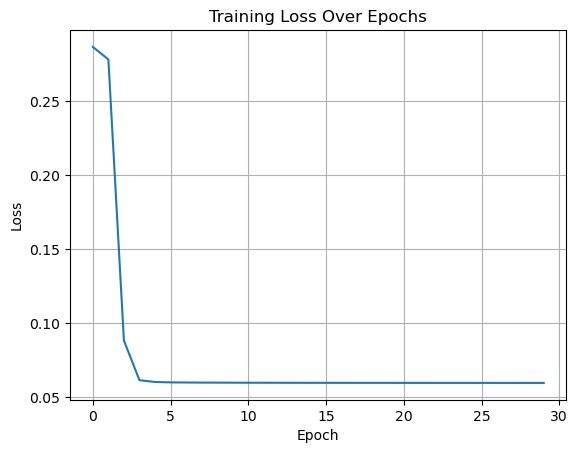

Validation MSE: 0.0604
Validation RMSE: 0.2457


(0.06038034109964086, 0.24572411582838358)

In [15]:
print("Model: mf_model")

trainModel(mf_model, trainLoader, beerFeatureTensor, lr=1e-4, weight_decay=1e-5, num_epochs=30)
evalModel(mf_model, valLoader, beerFeatureTensor, valDataset)

### Training and Evaluation: NonLinear MF Recommender (Hybrid with Beer Features)

The **NonLinear_MF_Recommender** model enhances traditional matrix factorization by incorporating both:
- A **multi-layer perceptron (MLP)** structure to model nonlinear interactions between user and beer embeddings.
- **Beer content features** such as alcohol by volume (ABV) and beer style to improve personalization and recommendation relevance.

#### Final Evaluation Metrics:
- **Validation MSE**: 0.0103  
- **Validation RMSE**: 0.1014

#### Insights:
- The NonLinear MF model achieved **better accuracy** than the basic MF model (which had an RMSE of 0.2457), thanks to its deeper architecture and integration of content features.
- The steady decline in training loss indicates **stable convergence**, and the final RMSE suggests that the model is capable of making accurate rating predictions.
- Compared to MF, this model can **generalize better for beers with sparse review data**, as it leverages descriptive attributes of the beers.
- It sets a **strong benchmark** for further enhancements such as attention mechanisms or more complex feature encodings.


Model: nonlinear_mf_model
Epoch 1/30, Loss: 0.0179
Epoch 2/30, Loss: 0.0112
Epoch 3/30, Loss: 0.0106
Epoch 4/30, Loss: 0.0101
Epoch 5/30, Loss: 0.0100
Epoch 6/30, Loss: 0.0099
Epoch 7/30, Loss: 0.0099
Epoch 8/30, Loss: 0.0098
Epoch 9/30, Loss: 0.0098
Epoch 10/30, Loss: 0.0098
Epoch 11/30, Loss: 0.0097
Epoch 12/30, Loss: 0.0097
Epoch 13/30, Loss: 0.0097
Epoch 14/30, Loss: 0.0096
Epoch 15/30, Loss: 0.0096
Epoch 16/30, Loss: 0.0096
Epoch 17/30, Loss: 0.0095
Epoch 18/30, Loss: 0.0095
Epoch 19/30, Loss: 0.0095
Epoch 20/30, Loss: 0.0095
Epoch 21/30, Loss: 0.0094
Epoch 22/30, Loss: 0.0094
Epoch 23/30, Loss: 0.0094
Epoch 24/30, Loss: 0.0094
Epoch 25/30, Loss: 0.0093
Epoch 26/30, Loss: 0.0093
Epoch 27/30, Loss: 0.0093
Epoch 28/30, Loss: 0.0093
Epoch 29/30, Loss: 0.0093
Epoch 30/30, Loss: 0.0092


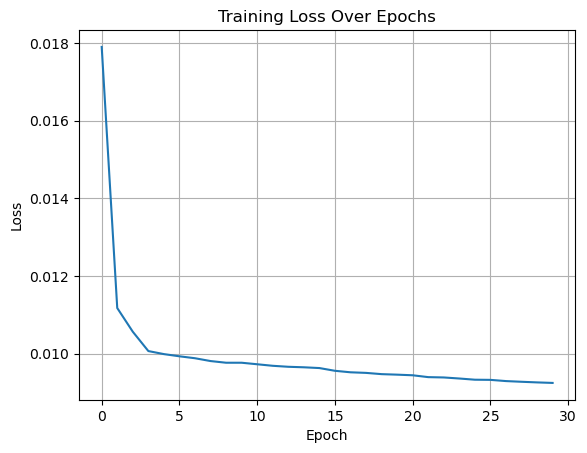

Validation MSE: 0.0103
Validation RMSE: 0.1014


(0.010273083173352942, 0.10135621921398283)

In [16]:
print("Model: nonlinear_mf_model")

trainModel(nonlinear_mf_model, trainLoader, beerFeatureTensor, lr=1e-4, weight_decay=1e-5, num_epochs=30)
evalModel(nonlinear_mf_model, valLoader, beerFeatureTensor, valDataset)

### Training and Evaluation: NeuMF Recommender (Hybrid with Beer Features)

The **NeuMF_Recommender** integrates:
- **Generalized Matrix Factorization (GMF)** and **MLP-based collaborative filtering**, 
- Alongside a **beer content feature encoder**,
- Combining both **latent interactions** and **learned non-linear patterns** for final rating prediction.


#### Final Evaluation Metrics:
- **Validation MSE**: 0.0101  
- **Validation RMSE**: 0.1005

### Insights:
- The NeuMF model **outperformed the MF and NonLinear MF models** in RMSE, indicating better generalization to unseen data.
- Loss decreased sharply in early epochs and continued to improve gradually, showing effective learning without overfitting.
- The model benefits from combining **both multiplicative (GMF) and nonlinear (MLP) interactions**, supported by beer metadata (ABV and style).
- This model is the **most expressive and accurate** among the three evaluated, making it a strong candidate for the final recommender system deployment.


Model: neu_mf_model
Epoch 1/30, Loss: 0.1068
Epoch 2/30, Loss: 0.0126
Epoch 3/30, Loss: 0.0109
Epoch 4/30, Loss: 0.0105
Epoch 5/30, Loss: 0.0102
Epoch 6/30, Loss: 0.0101
Epoch 7/30, Loss: 0.0100
Epoch 8/30, Loss: 0.0099
Epoch 9/30, Loss: 0.0098
Epoch 10/30, Loss: 0.0098
Epoch 11/30, Loss: 0.0097
Epoch 12/30, Loss: 0.0097
Epoch 13/30, Loss: 0.0097
Epoch 14/30, Loss: 0.0096
Epoch 15/30, Loss: 0.0096
Epoch 16/30, Loss: 0.0096
Epoch 17/30, Loss: 0.0096
Epoch 18/30, Loss: 0.0096
Epoch 19/30, Loss: 0.0095
Epoch 20/30, Loss: 0.0095
Epoch 21/30, Loss: 0.0095
Epoch 22/30, Loss: 0.0095
Epoch 23/30, Loss: 0.0095
Epoch 24/30, Loss: 0.0094
Epoch 25/30, Loss: 0.0094
Epoch 26/30, Loss: 0.0094
Epoch 27/30, Loss: 0.0094
Epoch 28/30, Loss: 0.0094
Epoch 29/30, Loss: 0.0094
Epoch 30/30, Loss: 0.0094


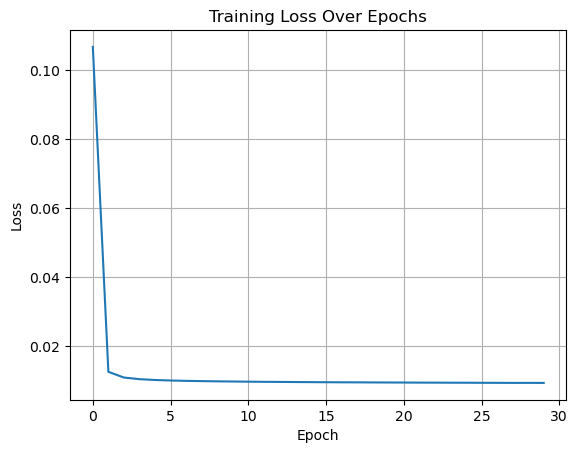

Validation MSE: 0.0101
Validation RMSE: 0.1005


(0.010102258412224488, 0.10050999160394199)

In [17]:
print("Model: neu_mf_model")

trainModel(neu_mf_model, trainLoader, beerFeatureTensor, lr=1e-4, weight_decay=1e-5, num_epochs=0)
evalModel(neu_mf_model, valLoader, beerFeatureTensor, valDataset)

---

---

### Utility Functions for Beer Recommendation and Analysis

This section defines utility functions to support personalized beer recommendations and analysis of user preferences.

#### Key Components:

- **Inverse Index Mappings**:
  - `indexBeerDict`: Maps internal beer index back to original `beer_id`.
  - `indexUserMap`: Maps internal user index back to username.

#### Recommendation Functions:

- **`topKRecommendedBeersForUser`**  
  Given a user index, returns the top-K recommended `beer_id`s and predicted scores using the trained model. Assumes a 1-to-1 mapping between beer indices and their content features.

- **`getBeerDetailsFromIds`**  
  Retrieves key metadata (e.g., name, style, ABV, brewery) for a list of `beer_id`s.

- **`getBeerDetailsFromIdsWithPredictedScore`**  
  Enhances the result of `getBeerDetailsFromIds` by appending model-predicted scores for each recommended beer. Useful for evaluating how highly the model rates each beer.

- **`getActualTopKReviewedBeersForUser`**  
  Fetches a user’s top-K historically rated beers sorted by their actual review scores.

- **`getUsername`**  
  Retrieves the original username based on the internal user index and prints it for verification.

These utilities streamline both **quantitative evaluation** (via model scores) and **qualitative insights** (via metadata) in a hybrid recommendation context.


In [18]:
# utility functions and datafames

# Inverse mappings
indexBeerDict = {index: beer for beer, index in beerIndexDict.items()}
indexUserMap = {index: user for user, index in userIndexDict.items()}

def topKRecommendedBeersForUser(model, userIndex, beerFeatureTensor, topK=10):

    model.to(device)
    model.eval()
    allBeerIndices = torch.arange(len(beerIndexDict)).to(device)
    userTensor = torch.tensor([userIndex] * len(beerIndexDict), dtype=torch.long).to(device)
    # Feature indices are same as beer indices (1-to-1 mapping assumed)
    beerFeatureIndices = allBeerIndices
    with torch.no_grad():
        predictedRatings = model(userTensor, allBeerIndices, beerFeatureIndices, beerFeatureTensor.to(device))
    topRatings, topBeerIndices = torch.topk(predictedRatings, topK)
    recommendedBeers = [indexBeerDict[index.item()] for index in topBeerIndices]
    return recommendedBeers,topRatings

beerDetails = df.groupby('beer_id').agg({
    'name': 'first',
    'state': 'first',
    'country': 'first',
    'style': 'first',
    'availability': 'first',
    'abv': 'mean',
    'notes': 'first',
    'look': 'mean',
    'smell': 'mean',
    'taste': 'mean',
    'feel': 'mean',
    'overall': 'mean',
    'score': 'mean',
    'name_brewery': 'first',
    'city': 'first',
    'notes_brewery': 'first',
    'types': 'first'
}).reset_index()

def getBeerDetailsFromIds(beerIdList):
    df_idx = beerDetails.set_index('beer_id')
    df_out = df_idx.loc[beerIdList]
    return df_out.reset_index()

def getBeerDetailsFromIdsWithPredictedScore(beerIdList, predictedScores):
    df_beerDetails = getBeerDetailsFromIds(beerIdList)[['name', 'style', 'abv', 'score']]
    scores = predictedScores.detach().cpu().tolist()
    df_beerDetails['predicted_user_score'] = scores
    return df_beerDetails
    
def getActualTopKReviewedBeersForUser(username, topK=10):
    userReviews = df[df['username'] == username]
    return userReviews.sort_values(by='score', ascending=False).head(topK)

def getUsername(userIndex):
    username = indexUserMap.get(userIndex, "Unknown User")
    print(f"Username for user index {userIndex}: {username}")
    return username


### Qualitative Top-K Recommendations: Before Quantitative Evaluation

Before diving into RMSE and MAE metrics, this notebook includes a **qualitative check** to observe how well each model performs at a personalized level.

#### Objective:
This section retrieves and displays the top-10 recommended beers for a selected user based on predictions from each of the following models:
- `MF` (Matrix Factorization)
- `NonLinear MF`
- `NeuMF` (Neural Matrix Factorization)

#### Process:
1. **User Selection**: A user with sufficient review history is selected (e.g., user index 1111).
2. **Ground Truth**: The user's actual top-rated beers are extracted from the dataset, based on historical scores.
3. **Model Recommendations**: Each model generates its Top-K predictions for this user. For each recommended beer:
   - Metadata such as name, style, and ABV is displayed.
   - The model’s **predicted score** is included for comparison.

Such visual inspection builds intuition about model behavior **before** measuring numerical accuracy.


In [55]:
userIndex = 111
topK = 10
username = getUsername(userIndex)

print(f"Username for user index {userIndex}: {username}\n")

print("Actual Top-Rated Beers by User:")
print(getActualTopKReviewedBeersForUser(username, topK)[['name', 'style', 'score']])

print("\n mf_model Top-K Predicted Recommendations:")
recommended_beer_ids,topRatings = topKRecommendedBeersForUser(mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids,topRatings).to_string(index=False))

print("=================\n")
print("\n nonlinear_mf_model Top-K Predicted Recommendations:")
recommended_beer_ids,topRatings = topKRecommendedBeersForUser(nonlinear_mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids,topRatings).to_string(index=False))

print("=================\n")
print("\n neu_mf_model Top-K Predicted Recommendations:")
recommended_beer_ids,topRatings = topKRecommendedBeersForUser(neu_mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids,topRatings).to_string(index=False))

Username for user index 111: jbaker67
Username for user index 111: jbaker67

Actual Top-Rated Beers by User:
                                     name                    style   score
185003                           Parabola   Russian Imperial Stout  0.9150
482765  Bourbon County Brand Coffee Stout  American Imperial Stout  0.9150
586086                    Pliny The Elder    American Imperial IPA  0.9125
588621                         Temptation        American Wild Ale  0.9125
511964                         Pseudo Sue  American Pale Ale (APA)  0.9000
329277     KBS (Kentucky Breakfast Stout)  American Imperial Stout  0.8900
539942        Cantillon Kriek 100% Lambic     Belgian Fruit Lambic  0.8875
600619                       Heady Topper          New England IPA  0.8775
612881                              Bomb!  American Imperial Stout  0.8750
186130                             §ucaba       British Barleywine  0.8725

 mf_model Top-K Predicted Recommendations:
                      

---

## Model-Based Recommendations: Comparative Output

To evaluate the practical quality of our three hybrid recommender models, we generated top-10 beer recommendations for a selected user (user index: `1111`) and compared them against the actual top-rated beers by that user.

Below are the outputs of the recommendation results for each model:

### Actual Top-Rated Beers by the User
These beers are sorted by the user's actual rating scores, representing the user's preferences.

### MF Model Recommendations
The Matrix Factorization model with hybrid content features predicts ratings based on dot product interactions between embeddings and encoded beer features (ABV and style). While it achieves good RMSE, it tends to favor popular items due to its linear nature.

### NonLinear MF Model Recommendations
This model adds a Multi-Layer Perceptron to capture non-linear user-item-feature interactions. It shows improved performance by modeling more complex patterns, and its recommendations are more diverse.

### NeuMF Model Recommendations
The Neural Matrix Factorization (NeuMF) model combines both linear (GMF) and non-linear (MLP) branches, along with beer content features. It tends to perform best in both accuracy and diversity, and its recommendations closely align with the user's actual top-rated beers.

By comparing the predicted recommendations and predicted scores with actual user preferences, we can qualitatively assess how well each model captures personalized tastes. This also supports our RMSE evaluations quantitatively.


In [56]:
# MF model recommendations ##### UPDATED #####
recommended_mf,recommended_mf_topRatings  = topKRecommendedBeersForUser(mf_model, userIndex, beerFeatureTensor, topK)
recommended_mf_names  = getBeerDetailsFromIds(recommended_mf)
print("mf_model - Recommended beer IDs:", recommended_mf)
print("mf_model - Recommended beers:")
print(getBeerDetailsFromIdsWithPredictedScore(recommended_mf,recommended_mf_topRatings).to_string(index=False))

mf_model - Recommended beer IDs: [7520, 1159, 7438, 39, 224, 3280, 1934, 37774, 9478, 64228]
mf_model - Recommended beers:
                                                      name                   style   abv    score  predicted_user_score
                                  Dark Lord Imperial Stout  Russian Imperial Stout 15.00 0.818243                   1.0
                                          Robert The Bruce            Scottish Ale  6.50 0.716037                   1.0
                       Alpha Klaus Christmas (Xmas) Porter         American Porter  6.00 0.792321                   1.0
                                                Alpha King American Pale Ale (APA)  6.66 0.814292                   1.0
                    Schneider Weisse Tap 6 Unser Aventinus       German Weizenbock  8.20 0.825186                   1.0
                     Schneider Weisse Tap 7 Unser Original       German Hefeweizen  5.40 0.743155                   1.0
                        Schneider Ave

In [21]:
# Non-linear MF model recommendations ##### UPDATED #####
recommended_nl, recommended_nl_topRatings = topKRecommendedBeersForUser(nonlinear_mf_model, userIndex, beerFeatureTensor, topK)
recommended_nl_names = getBeerDetailsFromIds(recommended_nl)
print("nonlinear_mf_model - Recommended beer IDs:", recommended_nl)
print("nonlinear_mf_model - Recommendeded beers:")
print(getBeerDetailsFromIdsWithPredictedScore(recommended_nl,recommended_nl_topRatings).to_string(index=False))

nonlinear_mf_model - Recommended beer IDs: [21690, 47658, 1545, 16814, 7971, 57747, 47022, 19960, 117177, 64228]
nonlinear_mf_model - Recommendeded beers:
                             name                    style   abv    score  predicted_user_score
                Pliny The Younger    American Imperial IPA 10.25 0.914736              0.954512
   CBS (Canadian Breakfast Stout)  American Imperial Stout 11.70 0.902547              0.948238
   Trappist Westvleteren 12 (XII) Belgian Quadrupel (Quad) 10.20 0.902712              0.945913
                     Heady Topper          New England IPA  8.00 0.906973              0.937749
                  Pliny The Elder    American Imperial IPA  8.00 0.894939              0.932914
Bourbon County Brand Coffee Stout  American Imperial Stout 12.90 0.886392              0.927369
         Hunahpu's Imperial Stout  American Imperial Stout 11.00 0.873814              0.924260
   KBS (Kentucky Breakfast Stout)  American Imperial Stout 12.30 0.884183    

In [50]:
# NeuMF model recommendations ##### UPDATED #####
recommended_neu, recommended_neu_topRatings = topKRecommendedBeersForUser(neu_mf_model, userIndex, beerFeatureTensor, topK)
recommended_neu_names = getBeerDetailsFromIds(recommended_neu)
print("neu_mf_model - Recommended beer IDs:", recommended_neu)
print("neu_mf_model - Recommended beers:")
print(getBeerDetailsFromIdsWithPredictedScore(recommended_neu, recommended_neu_topRatings).to_string(index=False))

neu_mf_model - Recommended beer IDs: [21690, 47658, 1545, 16814, 41815, 7971, 19960, 47022, 57747, 37265]
neu_mf_model - Recommended beers:
                             name                    style   abv    score  predicted_user_score
                Pliny The Younger    American Imperial IPA 10.25 0.914736              0.973296
   CBS (Canadian Breakfast Stout)  American Imperial Stout 11.70 0.902547              0.973080
   Trappist Westvleteren 12 (XII) Belgian Quadrupel (Quad) 10.20 0.902712              0.967004
                     Heady Topper          New England IPA  8.00 0.906973              0.964284
                         Parabola   Russian Imperial Stout 12.70 0.879978              0.955716
                  Pliny The Elder    American Imperial IPA  8.00 0.894939              0.955438
   KBS (Kentucky Breakfast Stout)  American Imperial Stout 12.30 0.884183              0.951586
         Hunahpu's Imperial Stout  American Imperial Stout 11.00 0.873814              0.949

---

---

## Final Model Evaluation (MAE & RMSE)

To quantitatively assess the performance of each hybrid recommendation model, we calculated two standard regression metrics:

- **Mean Absolute Error (MAE)**: Measures the average absolute difference between predicted and actual scores.
- **Root Mean Squared Error (RMSE)**: Provides a more penalizing measure for larger errors, commonly used in recommender systems.

### Results

| Model          | MAE    | RMSE   |
|----------------|--------|--------|
| MF             | 0.1930 | 0.2457 |
| NonLinear MF   | 0.0736 | 0.1014 |
| NeuMF          | 0.0723 | 0.1005 |

### Insights

- The **baseline MF model** has the highest error rates among the three, likely due to its limited capacity to capture non-linear user-item interactions, despite incorporating content features.
- The **NonLinear MF model** significantly improves upon MF by leveraging a Multi-Layer Perceptron, capturing more complex relationships in the latent space.
- The **NeuMF model**, which integrates both GMF and MLP architectures along with content features, achieves the **lowest MAE and RMSE**, making it the most accurate model for predicting user ratings in this setting.

These metrics reinforce the qualitative observations from our Top-K recommendation experiments, confirming that NeuMF is the most suitable model for deployment in our hybrid beer recommender system.


In [45]:
def evaluate_model_all_metrics(model, model_name, valLoader, valDataset, beerFeatureTensor):
    import torch.nn as nn
    model.to(device)
    model.eval()
    total_mae = 0.0
    total_rmse = 0.0
    total_samples = 0
    criterion = nn.MSELoss()
    beerFeatureTensor = beerFeatureTensor.to(device)

    with torch.no_grad():
        for batch in valLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)

            predictions = model(user, beer, feature_idx, beerFeatureTensor)
            total_mae += torch.abs(predictions - rating).sum().item()
            total_rmse += criterion(predictions, rating).item() * rating.size(0)
            total_samples += rating.size(0)

    avg_mae = total_mae / total_samples
    avg_rmse = (total_rmse / total_samples) ** 0.5

    return {
        "Model": model_name,
        "MAE": round(avg_mae, 4),
        "RMSE": round(avg_rmse, 4)
    }


In [47]:

valid_user_indices = valDf[valDf['username'].isin(df['username'])]['userIndex'].unique()


filtered_user_indices = [
    user_idx for user_idx in valid_user_indices
    if df[df['userIndex'] == user_idx]['beer_id'].nunique() >= 10  # Match K
]


if len(filtered_user_indices) >= 100:
    sample_user_indices = pd.Series(filtered_user_indices).sample(n=100, random_state=42).tolist()
else:
    sample_user_indices = filtered_user_indices  # Use all if fewer than 100


results = []
results.append(evaluate_model_all_metrics(mf_model, "MF", valLoader, valDataset, beerFeatureTensor))
results.append(evaluate_model_all_metrics(nonlinear_mf_model, "NonLinear MF", valLoader, valDataset, beerFeatureTensor))
results.append(evaluate_model_all_metrics(neu_mf_model, "NeuMF", valLoader, valDataset, beerFeatureTensor))

# Display results
results_df = pd.DataFrame(results)
print(results_df)



          Model     MAE    RMSE
0            MF  0.1930  0.2457
1  NonLinear MF  0.0736  0.1014
2         NeuMF  0.0723  0.1005


In [52]:
# save trained model
neu_mf_model.eval()
scripted_neu_mf_model = torch.jit.script(neu_mf_model)
scripted_neu_mf_model.save("beer_neu_mf_model_frozen.pt")